**Alumno: Matías Cano**  
**Padrón: 97925**

# TP de simulación 2: estimación espectral
## Ejercicio 1 - Estimador sesgado e insesgado de la autocorrelación

> _Genere un secuencia de 10000 realizaciones de ruido blanco gaussiano media nula y varianza unitaria. Estime las secuencias de autocovarianza utilizando los estimadores sesgado e insesgado de la correlación. Grafique ambos estimadores, el insesgado primero y arriba el sesgado. Compárelos con la autocovarianza teórica del ruido. ¿Qué observa y por qué?_

Estimador insesgado:

$$\hat{R_{Y}}(k) = \frac{1}{N-k} \sum_{n = k+1}^{N} Y(n)\;Y^{*}(n-k),\qquad 0\leq k \leq N-1$$

Estimador sesgado:

$$\hat{R_{Y}^{(s)}}(k) = \frac{1}{N} \sum_{n = k+1}^{N} Y(n)\;Y^{*}(n-k),\qquad 0\leq k \leq N-1$$


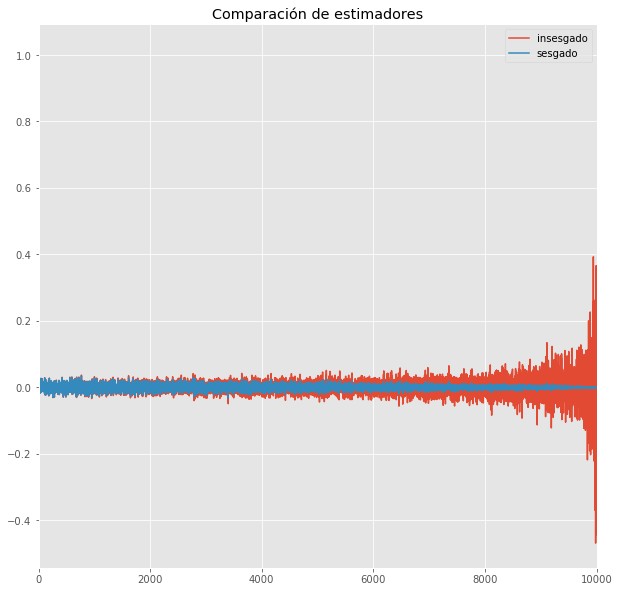

In [69]:
import numpy as np
import matplotlib.pyplot as plt

Y = np.random.normal(size=10000)

estimador_insesgado = lambda k,Y: sum(map(lambda i: i[0]*i[1],zip(Y, Y[k:])))/(Y.size-k)
estimador_sesgado = lambda k,Y: sum(map(lambda i: i[0]*i[1],zip(Y, Y[k:])))/(Y.size)

plt.figure().set_size_inches(10, 10)
plt.style.use('ggplot')

k_rango = np.arange(0,Y.size)

map_estimador_insesgado = lambda k: estimador_insesgado(k, Y)
map_estimador_insesgado = np.vectorize(map_estimador_insesgado)

map_estimador_sesgado = lambda k: estimador_sesgado(k, Y)
map_estimador_sesgado = np.vectorize(map_estimador_sesgado)

plt.plot(
    k_rango,
    map_estimador_insesgado(k_rango),
    label = "insesgado"
)

plt.plot(
    k_rango,
    map_estimador_sesgado(k_rango),
    label = "sesgado"
)
plt.title("Comparación de estimadores")
plt.xlim(0,Y.size)
plt.legend(loc='upper right')
plt.show()

En este gráfico se puede observar que al usar el estimador insesgado, a medida que aumenta k los resultados estimados poseen mayor variación. Esto se debe a que para cada k, los resultados se van ponderando por N-k. Entonces para valores grandes de k, se ponderan valores pequeños con N-k cada vez más chicos. Por el contrario, esto no sucede al utilizar el estimador sesgado, donde se pondera todo por N. De esta forma, se reducen las oscilaciones en valores grandes de k.

## Ejercicio 2 - (In)consistencia del periodograma

> _1. Grafique la verdadera densidad espectral de potencia de $Y$, $S_{Y}$._

Se debe tomar en cuenta que en tiempo discreto se cumple que:

$$ S_{Y}(\omega) = |\;H(e^{j\omega})\;|^{2}\;S_{X}(\omega)$$

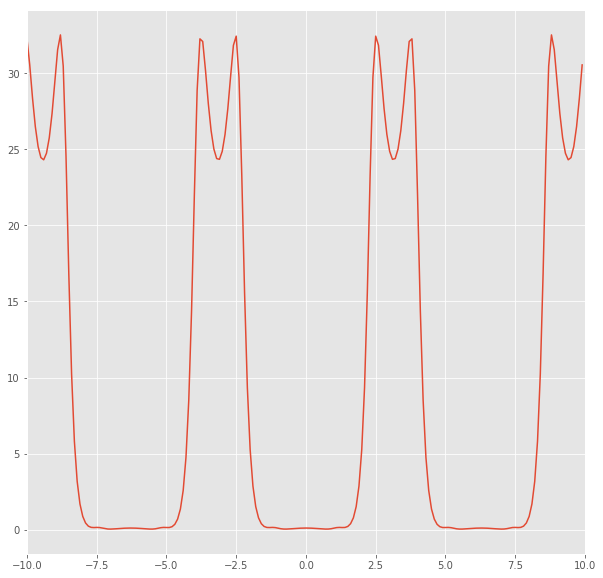

In [383]:
H_num = lambda z : (1 - 1.3817*z**(-1) + 1.5632*z**(-2) - 0.8843*z**(-3) + 0.4096*z**(-4))
H_den = lambda z : (1 + 0.3544*z**(-1) + 0.3508*z**(-2) + 0.1736*z**(-3) + 0.2401*z**(-4))
H = lambda z: H_num(z)/H_den(z)

densidad_espectral_X = lambda w: 1 #sigma^2

densidad_espectral_Y = lambda w: np.absolute(H(np.exp(w*1j)))**2 * densidad_espectral_X(w)
map_densidad_espectral_Y = np.vectorize(densidad_espectral_Y)

plt.figure().set_size_inches(10, 10)

w_rango = np.arange(-10,10,0.1)

plt.plot(
    w_rango,
    map_densidad_espectral_Y(w_rango)
)

plt.xlim(-10,10)

plt.show()

> _2. Genere para J = 100 realizaciones de largo N de X. Obtenga para cada i = 1,...,J el periodograma correspondiente, $S_{Y,i}$._

> _Realice un gráfico de $S_{Y}$ y superponga, para N = 64 y N = 512, las curvas de $\bar{\hat{S_{Y}}}$ y $\sigma_{\hat{S}_{Y}} \pm \bar{\hat{S_{Y}}}$. ¿Qué sucede con el desvío del estimador $\sigma_{\hat{S}_{Y}}$ a medida que incrementa N? ¿Observa algún cambio?_

In [437]:
from scipy.signal import lfilter
from numpy.fft import fft
from numpy.fft import fftfreq

def Sy_c(w, Ry, window):
    ret = 0
    for i in range(-(Ry.size-1),Ry.size):
        ret += Ry[abs(i)]*np.exp(1j*w*i).real*window[abs(i)]
    return ret

def graficos_de_Sy(N, window, nombre_ventana = ""):
    H_num_arr = np.array([1,-1.3817,1.5632,-0.8843,0.4096])
    H_den_arr = np.array([1,0.3544,0.3508,0.1736,0.2401])

    w_rango = np.arange(-10,10,0.1)
    Sy_i = np.zeros((100,w_rango.size)) # J=100 muestras de largo w_rango.size
    k_rango = np.arange(N)
    
    for i in range(100):
        X = np.random.normal(size=N)
        Y = lfilter(H_num_arr,H_den_arr,X)
        map_estimador_sesgado = lambda k: estimador_sesgado(k, Y)
        map_estimador_sesgado = np.vectorize(map_estimador_sesgado)
        Ry_i = map_estimador_sesgado(k_rango)
        for w_i in range(w_rango.size):
            Sy_i[i,w_i] = Sy_c(w_rango[w_i], Ry_i, window)

    Sy_p = np.mean(Sy_i,axis=0)

    desvio = np.sqrt(np.mean((Sy_i - Sy_p)**2, axis=0))
    
    plt.figure().set_size_inches(10, 10)

    plt.plot(
        w_rango,
        map_densidad_espectral_Y(w_rango),
        label="Densidad Espectral de Potencia Teórica"
    )

    plt.plot(
        w_rango,
        Sy_p,
        label="Periodograma promedio"
    )

    plt.plot(
        w_rango,
        desvio-Sy_p,
        label="$\sigma_{\hat{S}_{Y}}$ - $S_{Y}$"   
    )

    plt.plot(
        w_rango,
        desvio+Sy_p,
        label="$\sigma_{\hat{S}_{Y}}$ + $S_{Y}}$"   
    )
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title("Estimación de Densidad Espectral de Potencia - N="+str(N)+"\n"+nombre_ventana)
    
    plt.show()

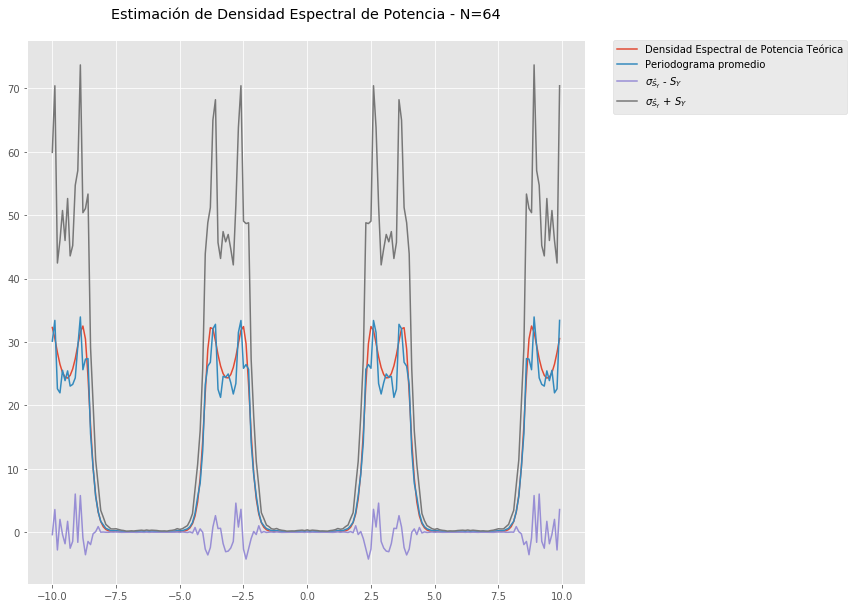

In [438]:
graficos_de_Sy(64, np.ones(64))

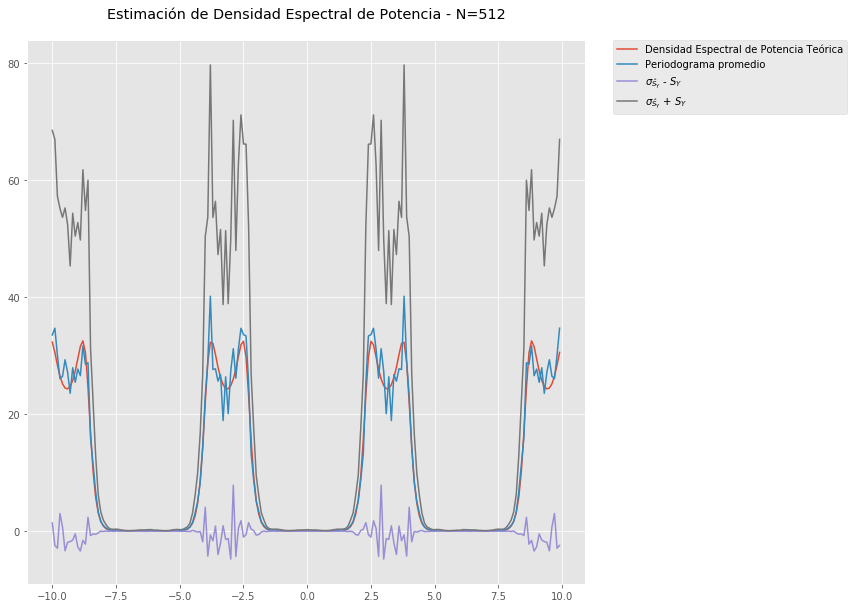

In [439]:
graficos_de_Sy(512, np.ones(512))

En los gráficos se puede observar que no hay una diferencia apreciable al incrementar N. A simple vista, la aproximación de la curva de Densidad Espectral de Potencia a la teórica es muy similar para N=64 y N=512. En ambos casos se observan oscilaciones en la curva del estimador. 
En cuanto al desvío estandar, se observa que toma más o menos los mismos valores tanto para N=64, como para N=512. Para los dos casos, el desvío toma valores grandes.

> _Ahora realice un grafico de $S_{Y}$ , $\bar{\hat{S_{Y}}}$ y $\sigma_{\hat{S}_{Y}} \pm \bar{\hat{S_{Y}}}$ para N = 256 en las condiciones del punto anterior (estimador de Blackman-Tukey con ventana rectangular y M = N). Superponga en este gráfico las mismas curvas pero utilizando una ventana de Bartlett (triangular) con M = N/4 y M = N/16_

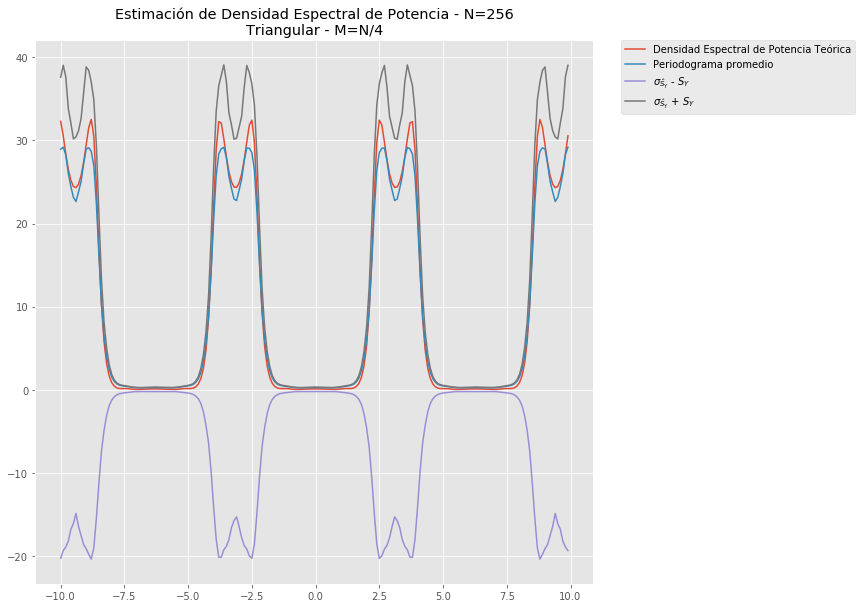

In [440]:
from scipy.signal import triang

window = triang(256/4)
window = window[window.size//2:]
window = np.pad(window, pad_width = (0,256-window.size), mode = "constant", constant_values = 0)

graficos_de_Sy(256, window, "Triangular - M=N/4")

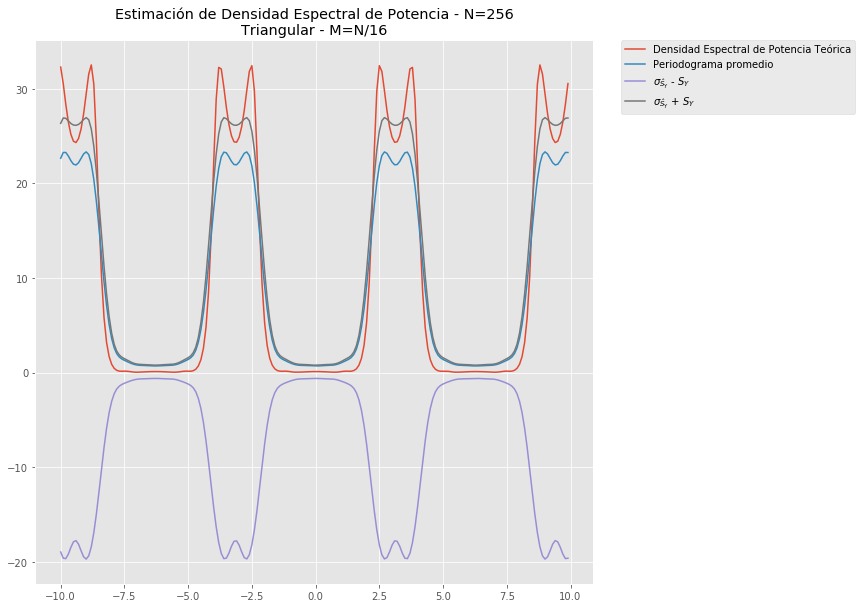

In [441]:
window = triang(256/16)
window = window[window.size//2:]
window = np.pad(window, pad_width = (0,256-window.size), mode = "constant", constant_values = 0)

graficos_de_Sy(256, window, "Triangular - M=N/16")

En el primero de estos dos gráficos se puede observar que con una ventana triangular de M=N/4 se obtiene una buena aproximación a la curva de Densidad Espectral de Potencial teórica. A diferencia de lo ocurrido con la ventana cuadrada, se observa que la curva es mucho más "suave" y posee menos oscilaciones. Asimismo, el desvío es mucho menor que el obtenido con la ventana cuadrada.
En el segundo gráfico, se observa que al usar una ventana de M=N/16 la aproximación a la curva de Densidad Espectral de Potencial empeora con respecto a la anterior.
Finalmente, se puede decir que la elección de la función ventana es importante para estimar la Densidad Espectral de Potencia de forma precisa. De la misma forma, la amplitud de esta ventana también es importante, pudiendo considerarse procesos correlacionados dentro de una vecindad.

## Conclusiones

A modo de conclusión, podemos decir que el estimador sesgado de la autocorrelación generalmente puede resultar más práctico que el insesgado. Esto se debe a sus comportamientos para valores de k altos, donde el insesgado pondera para pocos valores y resulta en estimaciones erráticas.
En cuanto a las estimaciones de Densidad Espectral de Potencia, se observa que con una ventana cuadrada la precisión no aumenta significativamente al aumentar N. Por el contrario, esto sí sucede al modificar la ventana por una ventana triangular. Para esta última, la precisión de los resultados depende del "ancho" de la ventana.


## Comentarios extras

Como se puede ver, los cálculos de $S_{Y}$ se realizaron calculando la sumatoria de forma "explícita", en lugar de obtener los resultados mediante la FFT. Esto último se probó, pero no se obtuvieron los resultados esperados, por este motivo se optó por realizar las sumatorias para distintos valores de $w$. En estos resultados, con la FFT, se puede ver que se encuentran desplazados en $\pi$. A continuación se encuentra el código utilizado, junto con el gráfico obtenido por el mismo.

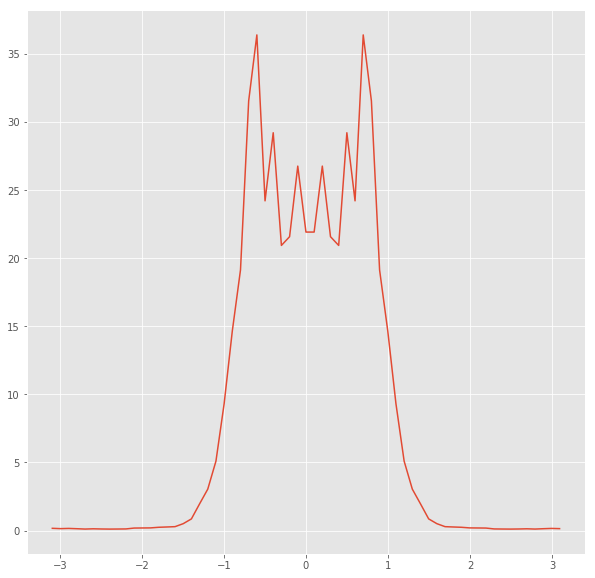

In [442]:
from scipy.signal import lfilter
from numpy.fft import fft
from numpy.fft import fftfreq

N = 64

H_num_arr = np.array([1,-1.3817,1.5632,-0.8843,0.4096])
H_den_arr = np.array([1,0.3544,0.3508,0.1736,0.2401])

w_rango = np.arange(-np.pi,np.pi,0.1)
Sy_i = np.zeros((100,w_rango.size))

for i in range(100):
    X = np.random.normal(size=N)
    Y = lfilter(H_num_arr,H_den_arr,X)
    map_estimador_sesgado = lambda k: estimador_sesgado(k, Y)
    map_estimador_sesgado = np.vectorize(map_estimador_sesgado)
    k_rango = np.arange(N)
    Ry_i = map_estimador_sesgado(k_rango)
    Sy_i[i] = 2*fft(Ry_i,w_rango.size).real - Ry_i[0]

plt.figure().set_size_inches(10, 10)
    
Sy_p = np.mean(Sy_i,axis=0)

plt.plot(
    np.sort(fftfreq(w_rango.size)*2*np.pi),
    Sy_p, 
    label = "Resultado con FFT"
)

plt.show()
